In [39]:
# import dependencies
%matplotlib inline
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#writer = pd.ExcelWriter('anova_pca_python.xlsx')

# Detect microbial contamination in FOS synthesis via spectroscopy

Enzymatic synthesis of FOS was modeled at test-tube size. The test tubes contain sucrose, and the enzyme. To model a microbial contamination, a microbe strain was also introduced to the test tubes, and then the tubes were set to incubate. Absorbance spectra [absorbance values in the wavelength range 200-1100 nm] were recorded at certain time points of the incubation.

The data contains 901 variables (absorbance values for every wavelength in 200-1100) for a total of 96 samples.
Factors of the experiment are: pepton source, initial sucrose content, time

## IMPORT & CLEAN UP RAW DATA

In [40]:
path = "c:/Users/furiu/Documents/UV/UV_FOS/contamination/anova_pca/spectra data/"
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f, header=1) for f in all_files)
data_all   = pd.concat(df_from_each_file, axis=1)

In [41]:
data_all.drop(['Unnamed: 0'], axis = 1, inplace=True) # drop the reoccuring variable

In [42]:
## RAW SPECTRA ##
spectra = data_all.T # transpose so rows correspond to observations, columns to variables
new_header = spectra.iloc[0] # assign the first row, containing the wavelength values as the header
raw_spectra = spectra[1:] # data starts at 2nd row
raw_spectra.columns = new_header # set the header row as the df header
pattern = r'[EFh0124578_.]'
raw_spectra = raw_spectra[raw_spectra.index.str.match(pattern)]
### export to excel ###
#raw_spectra.to_excel(writer,'raw_spectra')

Plot the spectra of all the observations in the data set.

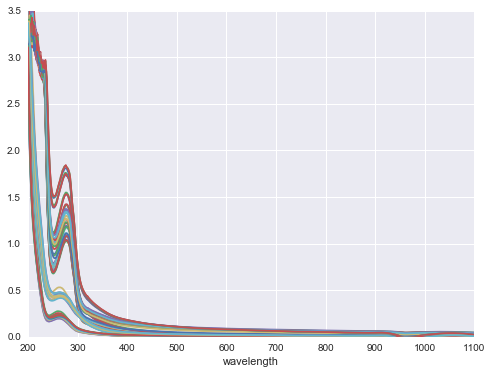

In [43]:
sns.set()
plt.figure()
raw_spectra.T.plot(ylim=(0,3.5), legend=False, figsize=(8,6))

## DATA PREPROCESSING FOR ANOVA-PCA

Standardize the data using a built in function (StandardScaler). It uses the formula: 

$$ z = \frac{x - \mu}{\sigma}$$

In [44]:
## SNV_SPECTRA ## standardize the raw spectra data
snv_spectra = StandardScaler().fit_transform(raw_spectra.values[:,:]) 
snv_spectra = pd.DataFrame(snv_spectra, index=raw_spectra.index, columns=raw_spectra.columns)

### export to excel ###
#snv_spectra.to_excel(writer,'snv_spectra')

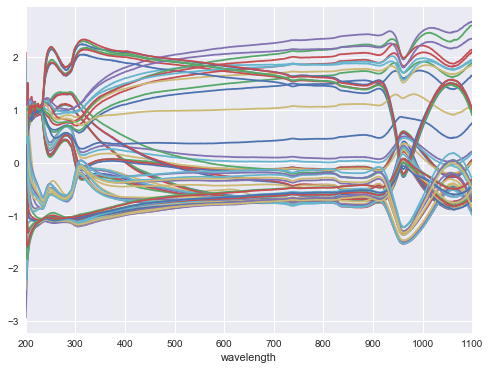

In [45]:
snv_spectra.T.plot(legend=False, figsize=(8,6))

## Matrix decomposition

In [46]:
## GRAND MEANS ##
GM = np.expand_dims(np.mean(snv_spectra.values[:,:], axis = 0), axis=1).T # compute means
GM = pd.DataFrame(GM, columns=raw_spectra.columns) # rename header

### export to excel ###
#GM.to_excel(writer,'grand_means')

In [47]:
## GRAND MEANS RESIDUALS ##
GMRS = np.subtract(snv_spectra.values[:,:], GM.values[:,:]) # matrix subtraction (snv_spectra-GM)
GMRS = pd.DataFrame(GMRS, index=raw_spectra.index, columns=raw_spectra.columns) # rename header & indices
### export to excel ###
#GMRS.to_excel(writer,'grand_means_residuals')

In [48]:
## FACTOR2 (enzyme vs pepton) ##
# enzyme
enzyme = np.expand_dims(np.mean(GMRS[GMRS.index.str.contains('_E')], axis=0), axis=1).T
# pepton
pepton = np.expand_dims(np.mean(GMRS[GMRS.index.str.contains('_F')], axis=0), axis=1).T

In [49]:
## FACTOR2 (enzyme vs pepton) ##
# append the two averages to their corresponding rows in the factor2_means matrix
factor2_means = pd.DataFrame(index = GMRS.index, columns = GMRS.columns)

ind = GMRS.index.str.contains('_E')

for i, val in enumerate(ind):
    if val == True:
        factor2_means.iloc[i] = enzyme
    else:
        factor2_means.iloc[i] = pepton
        
#factor2_means.to_excel(writer,'factor2_means')

In [50]:
## FACTOR2 residuals ##
F2RS = np.subtract(GMRS.values[:,:], factor2_means.values[:,:])
F2RS = pd.DataFrame(F2RS, index=raw_spectra.index, columns=raw_spectra.columns)
#F2RS.to_excel(writer,'F2RS')

In [51]:
## SUGARDOSE (5%, 10%, 40%) ##
cc5 = np.expand_dims(np.mean(F2RS[F2RS.index.str.contains('_5_')], axis=0), axis=1).T

cc10 = np.expand_dims(np.mean(F2RS[F2RS.index.str.contains('_10_')], axis=0), axis=1).T

cc40 = np.expand_dims(np.mean(F2RS[F2RS.index.str.contains('_40_')], axis=0), axis=1).T

In [52]:
## SUGARDOSE (5%, 10%, 40%) ##
# append the four averages to their corresponding rows in the factor3_means matrix
cc_treat = pd.DataFrame(index = GMRS.index, columns = GMRS.columns)
ind = GMRS.index

for i, val in enumerate(ind):
    if '_5_' in val:
        cc_treat.iloc[i] = cc5
    elif '_10_' in val:
        cc_treat.iloc[i] = cc10
    elif '_40_' in val:
        cc_treat.iloc[i] = cc40
        
#cc_treat.to_excel(writer,'cc_means')

In [53]:
## SUGARDOSE residuals ##
CCRS = np.subtract(F2RS.values[:,:], cc_treat.values[:,:])
CCRS = pd.DataFrame(CCRS, index=raw_spectra.index, columns=raw_spectra.columns)
#CCRS.to_excel(writer,'CCRS')

In [54]:
## TIME (0h 24h 48h 72h [4 levels]) ##

t0 = np.expand_dims(np.mean(CCRS[CCRS.index.str.contains('0h_')], axis=0), axis=1).T

t24 = np.expand_dims(np.mean(CCRS[CCRS.index.str.contains('24h_')], axis=0), axis=1).T

t48 = np.expand_dims(np.mean(CCRS[CCRS.index.str.contains('48h_')], axis=0), axis=1).T

t72 = np.expand_dims(np.mean(CCRS[CCRS.index.str.contains('72h_')], axis=0), axis=1).T  

In [55]:
## TIME (0h 24h 48h 72h [4 levels]) ##
# append the four averages to their corresponding rows in the factor3_means matrix
t_treat = pd.DataFrame(index = GMRS.index, columns = GMRS.columns)
ind = GMRS.index

for i, val in enumerate(ind):
    if '0h_' in val:
        t_treat.iloc[i] = t0
    elif '24h_' in val:
        t_treat.iloc[i] = t24
    elif '48h_' in val:
        t_treat.iloc[i] = t48
    elif '72h_' in val:
        t_treat.iloc[i] = t72
        
#t_treat.to_excel(writer,'t_means')

In [56]:
## TIME residuals ##
TRS = np.subtract(CCRS.values[:,:], t_treat.values[:,:])
TRS = pd.DataFrame(TRS, index=raw_spectra.index, columns=raw_spectra.columns)
#TRS.to_excel(writer,'TRS')

In [57]:
#writer = pd.ExcelWriter('anova_pca_python.xlsx')

## PCA

In [58]:
from pca_plot import pca, pca_plot, cov_ellipse

[]

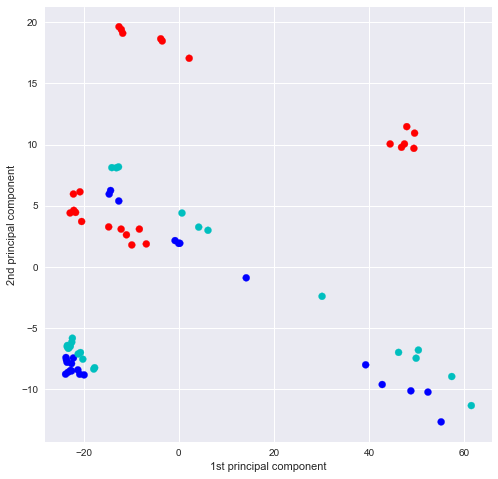

In [59]:
pca(GMRS, '', cc='c')

## ANOVA-PCA

[]

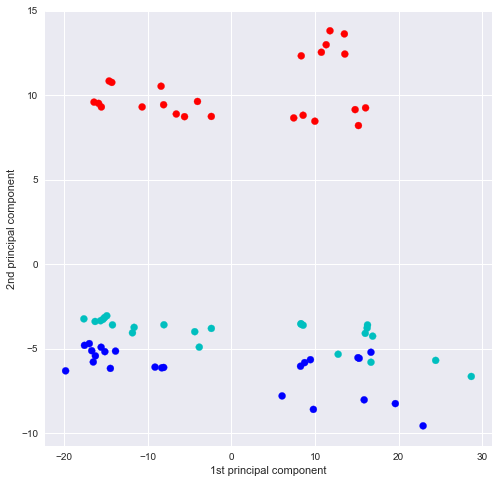

In [60]:
test1 =  cc_treat + TRS
pca(test1, '', cc='c')

In [38]:
# TODO
# reference measurement sampling error -> redo experiment